In [21]:
import xarray as xr
import os
import oscarplus as op
import matplotlib.pyplot as plt
import plot_helpers as ph
import subplots as splot
import cartopy.crs as ccrs
import numpy as np
from oscarplus.processing.secondary_products import calculate_upwelling_SWT
from matplotlib.colors import LinearSegmentedColormap

# Making figures 1, 2 and 4

## Input parameters for plotting

In [22]:
# OSCAR
date = "20220517"
track = "2"
gmf = "mouche12kp20_rsv20"
# MARS
MARS2DTIME = "2022-05-17T09:30:00.000000000"
MARS3DTIME = "2022-05-17T09:00:00.000000000"
# plotting parameters
MARS2D_extent = [-5.18, -5.05, 48.368, 48.525]
MARS3D_extent = [
    MARS2D_extent[0] - 0.02,
    MARS2D_extent[1] + 0.02,
    MARS2D_extent[2] - 0.02,
    MARS2D_extent[3] + 0.02,
]

## Load and process data for single day plots and transects

In [23]:
# load bathymetry
bathymetry_path = op.tools.readers.get_data_dirs()["bathymetry"]
bathymetry = xr.open_mfdataset(
    os.path.join(bathymetry_path, "Iroise_Sea_Bathymetry_EMODnet.nc")
)  # change path to select a different file

# load OSCAR
OSCAR, _ = op.tools.readers.read_OSCAR(date, track, gmf, "L2a MF")
calculate_upwelling_SWT(OSCAR, -bathymetry["elevation"])  # add currentW to L2a_MF
OSCAR = op.tools.utils.cut_NaNs(OSCAR)

# load MARS2D
MARS2D = op.tools.readers.read_MARS2D(
    "MARC_L1-MARS2D-FINIS250_SEASTAREX_20220517.nc", 250
)
MARS2D = MARS2D.sel(time=MARS2DTIME)
MARS2D = op.tools.utils.cut_to_extent(MARS2D, MARS2D_extent)
op.processing.secondary_products.calculate_secondary_products(MARS2D)
calculate_upwelling_SWT(MARS2D, -bathymetry["elevation"])  # add currentW to MARS2D

# load MARS3D
MARS3D = op.tools.readers.read_MARS3D(
    "MARC_F1-MARS3D-MANGAE2500_SEASTAREX_20220517.nc", 2500
)
MARS3D = MARS3D.sel(time=MARS3DTIME)
MARS3D = op.tools.utils.cut_to_extent(MARS3D, MARS3D_extent)
op.processing.secondary_products.calculate_secondary_products(MARS3D)

C:\Users\arius\python_modules\oscarplus\tools\utils.py:661: UserWarning: EarthRelativeWindU and EarthRelativeWindV not found in L2_AR_MF
  warnings.warn("EarthRelativeWindU and EarthRelativeWindV not found in L2_AR_MF")
C:\Users\arius\python_modules\oscarplus\tools\utils.py:661: UserWarning: EarthRelativeWindU and EarthRelativeWindV not found in L2_AR_MF
  warnings.warn("EarthRelativeWindU and EarthRelativeWindV not found in L2_AR_MF")
C:\Users\arius\python_modules\oscarplus\tools\utils.py:661: UserWarning: EarthRelativeWindU and EarthRelativeWindV not found in L2_AR_MF
  warnings.warn("EarthRelativeWindU and EarthRelativeWindV not found in L2_AR_MF")


In [24]:
# Take transects
current_transect_north, elevation_transect_north = op.tools.utils.transect(
    OSCAR,
    bathymetry,
    iGround=0,
    jCross=59,
    angle=225,
)
current_transect_south, elevation_transect_south = op.tools.utils.transect(
    OSCAR,
    bathymetry,
    iGround=10,
    jCross=19,
    angle=135,
)

## Make figures

In [25]:
# Functions

# Colourmap used for bathymetry on the secondary product plots
Bathymetrycmap = LinearSegmentedColormap.from_list(
    "Bathymetrycmap",
    [
        [0.0, "#777777"],
        [0.5, "#444444"],
        [1.0, "#000000"],
    ],
)


def plot_all_three_on_one(
    DS,
    bathymetry,
    figsize,
    legend_location="upper right",
    xoffset=0,
    yoffset=0,
):
    """Plot the current, divergence and vertical current on the same figure"""
    _, axes, extent = ph.make_axes(
        DS,
        1,
        3,
        figsize=figsize,
        dpi=300,
        title=None,
        xoffset=xoffset,
        yoffset=yoffset,
    )

    depth = -bathymetry["elevation"]

    cmaps = ["YlGn", Bathymetrycmap, Bathymetrycmap]

    # Plot bathymetry
    for ax, cmap in zip(axes, cmaps):
        splot.contours(
            depth,
            ax=ax,
            extent=extent,
            vmin=40,
            vmax=120,
            level_step=20,
            legend_title="Depth",
            linewidths=0.8,
            legend_location=legend_location,
            cmap=cmap,
        )

    # Plot current
    splot.quiver_with_background(
        DS,
        ax=axes[0],
        selection="Current",
        title="Horizontal surface current",
        extent=extent,
        coarsen_arrows=True,
        vmax=3.2,
    )
    # Plot divergence
    gl2 = splot.single(
        DS["CurrentDivergence"],
        ax=axes[1],
        extent=extent,
        title="Surface current divergence",
        cbar_label="Divergence/f",
        vmax=20,
    )
    # Plot vertical current
    gl3 = splot.single(
        DS["CurrentW"],
        ax=axes[2],
        extent=extent,
        title="Vertical surface current",
        cbar_label="Current velocity [$ms^{-1}$]",
        vmax=0.2,
    )

    # Remove left labels from the middle and right plot
    gl2.left_labels = False
    gl3.left_labels = False

    ph.add_letters(axes)
    plt.subplots_adjust(wspace=0.05)

    return axes


def plot_transects(
    current_transects,
    elevation_transects,
    symmetric_velocity=False,
):
    """Plot the transects of the current velocity and the elevation"""

    def make_axes_lim_symmetric(ax):
        """Make the y-axis symmetric around 0"""
        ylim = ax.get_ylim()
        max_lim = max(abs(ylim[0]), abs(ylim[1]))
        ax.set_ylim(-max_lim, max_lim)

    def set_elevation_axis_limits(ax, df_el):
        """
        Set the limits of the elevation axis
        Limits are set to the maximum depth and 0
        """
        max_el = df_el["elevation"].max()
        ax.set_ylim(max_el, 0)

    def velocity_subplot(df_current, df_elevation, ax, max_velocity):
        """Plot the velocity and elevation on the given axis"""
        # make more axis
        ax1 = ax
        ax_velocity = ax1.twinx()  # velocity full
        ax3 = ax1.twinx()  # velocity along
        ax4 = ax1.twinx()  # velocity across
        subaxes = [ax3, ax4]

        # configure spines to avoid overlap
        starting_distance = 40
        for iax in subaxes:
            # Shift the spine outward from the right
            iax.spines["right"].set_position(("outward", starting_distance))
            iax.spines["right"].set_visible(False)  # Hide the default right spine
            iax.set_yticklabels([])
            iax.set_yticks([])
            starting_distance += 10

        # plot elevation
        ax1.invert_yaxis()
        ax1.set_xlabel("Distance [m]")
        ph.plot_column(
            "elevation",
            ax1,
            depth_col,
            "Depth [$m$]",
            df=df_elevation,
            alpha=0.3,
        )
        ax1.fill_between(
            df_elevation["distance"],
            ax1.get_ylim()[0],
            df_elevation["elevation"],
            color=depth_col,
            alpha=0.3,
        )
        set_elevation_axis_limits(ax1, df_elevation)

        # Plot CurrentVelocity
        ph.plot_column(
            "CurrentVelocity",
            ax_velocity,
            "blue",
            df=df_current,
            label="|Horizontal surface velocity| [$ms^{-1}$]",
        )
        ax_velocity.tick_params(axis="y", labelcolor="black")
        ax_velocity.set_ylim(bottom=0, top=max_velocity)

        # Plot CurrentVelocity_along_transect
        ph.plot_column(
            "CurrentVelocity_along_transect",
            ax3,
            velocity_along_col,
            df=df_current,
            label="|Horizontal surface velocity along transect| [$ms^{-1}$]",
            abs_val=True,
        )
        ax3.set_ylim(ax_velocity.get_ylim())

        # Plot CurrentVelocity_across_transect
        ph.plot_column(
            "CurrentVelocity_across_transect",
            ax4,
            "xkcd:light blue",
            "|Horizontal surface velocity across transect| [$ms^{-1}$]",
            df=df_current,
            abs_val=True,
        )
        ax4.set_ylim(ax_velocity.get_ylim())

        ax1.set_xlim(0, df_current["distance"].max())
        for ax in subaxes:
            ax.set_xlim(0, df_current["distance"].max())

    def secondary_subplot(df_current, df_elevation, ax):
        # Make more y-axis
        ax1 = ax
        ax2 = ax1.twinx()
        ax3 = ax1.twinx()
        ax4 = ax1.twinx()

        # Now configure all axis
        ax3.spines["left"].set_position(
            ("outward", 50)
        )  # Shift the spine outward from the left
        ax3.spines["right"].set_visible(False)  # Hide the default right spine
        ax4.spines["right"].set_position(
            ("outward", 60)
        )  # Hide the default right spine

        # plot elevation
        ax1.invert_yaxis()
        ax1.set_xlabel("Distance [m]")
        ph.plot_column(
            "elevation",
            ax1,
            depth_col,
            "Depth [$m$]",
            df=df_elevation,
            alpha=0.3,
        )
        ax1.fill_between(
            df_elevation["distance"],
            ax1.get_ylim()[0],
            df_elevation["elevation"],
            color=depth_col,
            alpha=0.3,
        )
        set_elevation_axis_limits(ax1, df_elevation)

        ph.plot_column(
            "CurrentDivergence",
            ax2,
            "#D81B60",
            "Divergence/f",
            linestyle="dashdot",
            df=df_current,
        )
        make_axes_lim_symmetric(ax2)
        ax2.axhline(0, color="gray", linestyle="--", linewidth=0.7)

        # plot current velocity along transect
        ph.plot_column(
            "CurrentVelocity_along_transect",
            ax3,
            velocity_along_col,
            "Horizontal surface velocity along transect [$ms^{-1}$]",
            df=df_current,
        )
        ax3.yaxis.set_label_position("left")
        ax3.yaxis.set_ticks_position("left")
        if symmetric_velocity:
            make_axes_lim_symmetric(ax3)
        # Plot CurrentW
        ph.plot_column(
            "CurrentW",
            ax4,
            "black",
            "Vertical surface velocity [$ms^{-1}$]",
            linestyle=CurrentW_style,
            df=df_current,
        )
        make_axes_lim_symmetric(ax4)

        subaxes = (ax1, ax2, ax3)
        for ax in subaxes:
            ax.set_xlim(0, df_current["distance"].max())

    # Set the colours and styles
    depth_col = "#FFC107"
    velocity_along_col = "#1E88E5"
    CurrentW_style = "dotted"
    max_velocity = [2.1, 2.1]

    # Create the subplots
    _, axes = plt.subplots(2, len(current_transects), figsize=(15, 10))
    ph.add_letters(axes)
    plt.subplots_adjust(
        left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.9, hspace=0.3
    )


    # Plot the transects
    for i in range(len(current_transects)):
        velocity_subplot(
            current_transects[i], elevation_transects[i], axes[0, i], max_velocity[i]
        )
        secondary_subplot(current_transects[i], elevation_transects[i], axes[1, i])

    axes[0][0].set_title("Northern jet transect: current velocity")
    axes[0][1].set_title("Southern jet transect: current velocity")
    axes[1][0].set_title("Northern jet transect: divergence and vertical current")
    axes[1][1].set_title("Southern jet transect: divergence and vertical current")


def plot_MARS2D_and_MARS3D_profiles(
    MARS2D,
    MARS3D,
    bathymetry,
    figsize,
    levels,
    points,
    legend_location="upper right",
    xoffset=0,
    yoffset=0,
):
    def plot_vertical(ax, DS, da_name, title, points, xlabel, ylabel):
        ax.scatter(
            DS[da_name].isel(GroundRange=points[0][0], CrossRange=points[0][1]),
            -DS.isel(GroundRange=points[0][0], CrossRange=points[0][1])["level"],
            s=3,
            label="Point A",
        )
        ax.scatter(
            DS[da_name].isel(GroundRange=points[1][0], CrossRange=points[1][1]),
            -DS.isel(GroundRange=points[1][0], CrossRange=points[1][1])["level"],
            s=3,
            label="Point B",
        )
        ax.invert_yaxis()
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.legend(loc="lower left")

    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 3)

    top_axes = [None, None, None]
    bottom_axes = [None, None, None]

    for i in range(3):
        top_axes[i] = fig.add_subplot(gs[0, i], projection=ccrs.PlateCarree())

    bottom_axes[0] = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
    bottom_axes[1] = fig.add_subplot(gs[1, 1])
    bottom_axes[2] = fig.add_subplot(gs[1, 2])

    extent = [
        MARS2D.longitude.min().values + xoffset,
        MARS2D.longitude.max().values - xoffset,
        MARS2D.latitude.min().values + yoffset,
        MARS2D.latitude.max().values - yoffset,
    ]

    depth = -bathymetry["elevation"]

    # TOP ROW
    cmaps = ["YlGn", Bathymetrycmap, Bathymetrycmap]

    # Plot bathymetry
    for ax, cmap in zip(top_axes, cmaps):
        splot.contours(
            depth,
            ax=ax,
            extent=extent,
            vmin=40,
            vmax=120,
            level_step=20,
            legend_title="Depth",
            linewidths=0.8,
            legend_location=legend_location,
            cmap=cmap,
        )

    # Plot current
    gl1 = splot.quiver_with_background(
        MARS2D,
        ax=top_axes[0],
        selection="Current",
        title="MARS2D horizontal surface current",
        extent=extent,
        coarsen_arrows=True,
        vmax=3.2,
    )
    # Plot divergence
    gl2 = splot.single(
        MARS2D["CurrentDivergence"],
        ax=top_axes[1],
        extent=extent,
        title="MARS2D surface current divergence",
        cbar_label="Divergence/f",
        vmax=20,
    )
    # Plot vertical current
    gl3 = splot.single(
        MARS2D["CurrentW"],
        ax=top_axes[2],
        extent=extent,
        title="MARS2D vertical surface current",
        cbar_label="Current velocity [$ms^{-1}$]",
        vmax=0.2,
    )

    # Remove left labels from the middle and right plot
    gl1.bottom_labels = False
    gl2.bottom_labels = False
    gl3.bottom_labels = False
    gl2.left_labels = False
    gl3.left_labels = False

    # BOTTOM ROW
    quiver_kwargs = {
        "vmax": 3.2,
        "scale": 8,
        "headwidth": 5,
        "headlength": 5,
    }

    # Plot bathymetry
    splot.contours(
        depth,
        ax=bottom_axes[0],
        extent=extent,
        vmin=40,
        vmax=120,
        level_step=20,
        legend_title="Depth",
        linewidths=0.8,
        legend_location=legend_location,
        cmap="YlGn",
    )

    # Plot current
    splot.quiver_with_background(
        MARS3D.sel(level=levels[0]),
        ax=bottom_axes[0],
        selection="Current",
        title=f"MARS3D current at depth of {-levels[0]}$h$",
        extent=extent,
        coarsen_arrows=False,
        **quiver_kwargs,
    )

    for i in range(2):
        bottom_axes[0].plot(
            MARS3D["longitude"].isel(GroundRange=points[i][0], CrossRange=points[i][1]),
            MARS3D["latitude"].isel(GroundRange=points[i][0], CrossRange=points[i][1]),
            marker="*",
            color="white",
            markersize=7,
            transform=ax.projection,
        )
    for i in range(2):
       top_axes[0].plot(
            MARS3D["longitude"].isel(GroundRange=points[i][0], CrossRange=points[i][1]),
            MARS3D["latitude"].isel(GroundRange=points[i][0], CrossRange=points[i][1]),
            marker="*",
            color="white",
            markersize=7,
            transform=ax.projection,
        )

    bottom_axes[0].text(
        MARS3D["longitude"].isel(GroundRange=points[0][0], CrossRange=points[0][1])
        - 0.002,
        MARS3D["latitude"].isel(GroundRange=points[0][0], CrossRange=points[0][1])
        + 0.0035,
        "A",
        fontsize=10,
        color="white",
        transform=ax.projection,
    )
    bottom_axes[0].text(
        MARS3D["longitude"].isel(GroundRange=points[1][0], CrossRange=points[1][1])
        - 0.00175,
        MARS3D["latitude"].isel(GroundRange=points[1][0], CrossRange=points[1][1])
        + 0.0035,
        "B",
        fontsize=10,
        color="white",
        transform=ax.projection,
    )
    top_axes[0].text(
        MARS3D["longitude"].isel(GroundRange=points[0][0], CrossRange=points[0][1])
        - 0.002,
        MARS3D["latitude"].isel(GroundRange=points[0][0], CrossRange=points[0][1])
        + 0.0035,
        "A",
        fontsize=10,
        color="white",
        transform=ax.projection,
    )
    top_axes[0].text(
        MARS3D["longitude"].isel(GroundRange=points[1][0], CrossRange=points[1][1])
        - 0.00175,
        MARS3D["latitude"].isel(GroundRange=points[1][0], CrossRange=points[1][1])
        + 0.0035,
        "B",
        fontsize=10,
        color="white",
        transform=ax.projection,
    )

    plot_vertical(
        bottom_axes[1],
        MARS3D,
        "CurrentVelocity",
        title = "MARS3D horizontal current velocity vs depth",
        points = points,
        xlabel = "Horizontal current velocity [m/s]",
        ylabel = "Depth as fraction of total depth $h$",
    )
    plot_vertical(
        bottom_axes[2],
        MARS3D,
        "CurrentDirection",
        title = "MARS3D horizontal current direction vs depth",
        points = points,
        xlabel = "Direction [$°$]",
        ylabel = "Depth as fraction of total depth $h$",
    )
    bottom_axes[1].set_xlim(0, 3)
    bottom_axes[2].set_xlim(0, 360)

    # ax.plot(
    #     -5.24826884,
    #     48.25578528,
    #     marker="*",
    #     color="black",
    #     markersize=8,
    #     transform=ax.projection,
    # )

    plt.subplots_adjust(
        left=0.1, right=0.9, top=0.92, bottom=0.1, hspace=0.2, wspace=0.25
    )
    axes = np.concatenate((top_axes, bottom_axes))
    ph.add_letters(axes)

    return axes

Max velocity: 2.849035740832982
Divergence range: -34.30106755334558,27.914694850312614
Vertical velocity range: -0.2648135470685569,0.2631405599868695


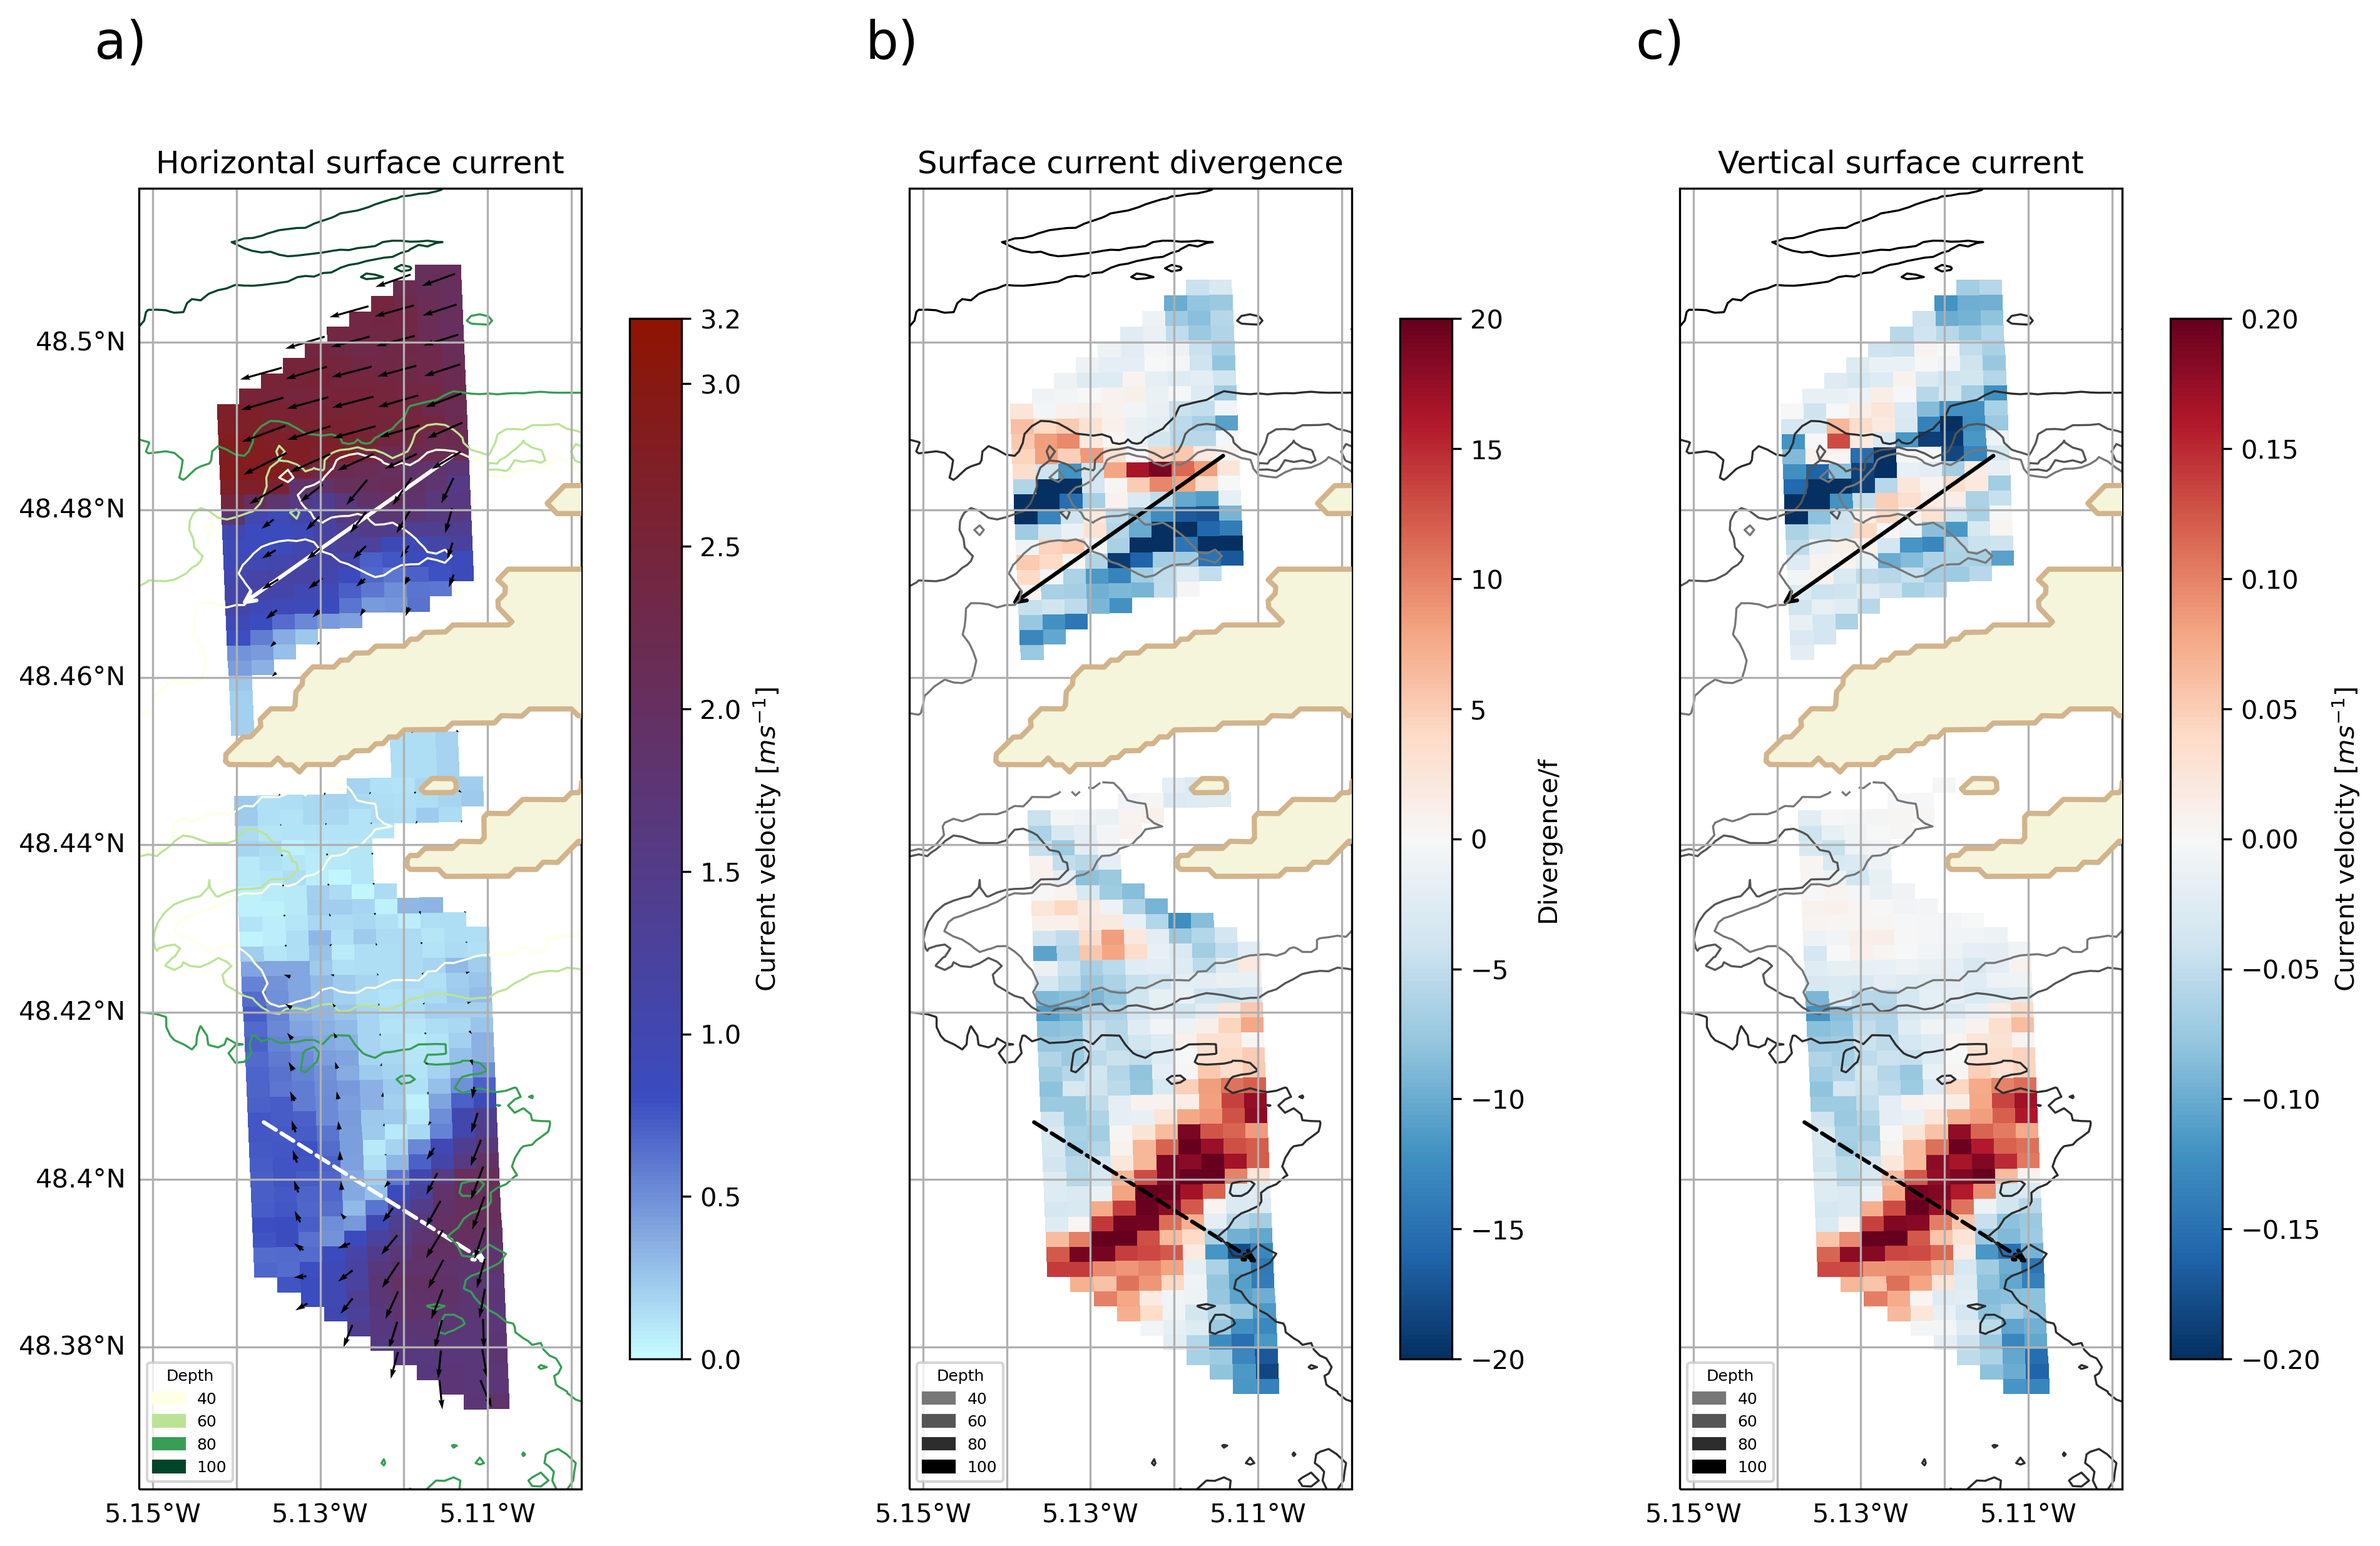

In [26]:
# plot figure 1
axes = plot_all_three_on_one(
    DS=OSCAR,
    bathymetry=bathymetry,
    figsize=(15, 9),
    legend_location="lower left",
    xoffset=-0.01,
    yoffset=-0.01,
)

# find the coordinates of the transects
coordinates_north = ph.extract_transect_range(current_transect_north)
coordinates_south = ph.extract_transect_range(current_transect_south)

# add arrows
ph.add_arrow(axes[0], **coordinates_north, color="white", linewidth=1.5)
for ax in axes[1:]:
    ph.add_arrow(ax, **coordinates_north, color="black", linewidth=1.5)

ph.add_arrow(axes[0], **coordinates_south, color="white", linewidth=1.5, linestyle="--")
for ax in axes[1:]:
    ph.add_arrow(ax, **coordinates_south, color="black", linewidth=1.5, linestyle="--")

ph.print_ranges(OSCAR)

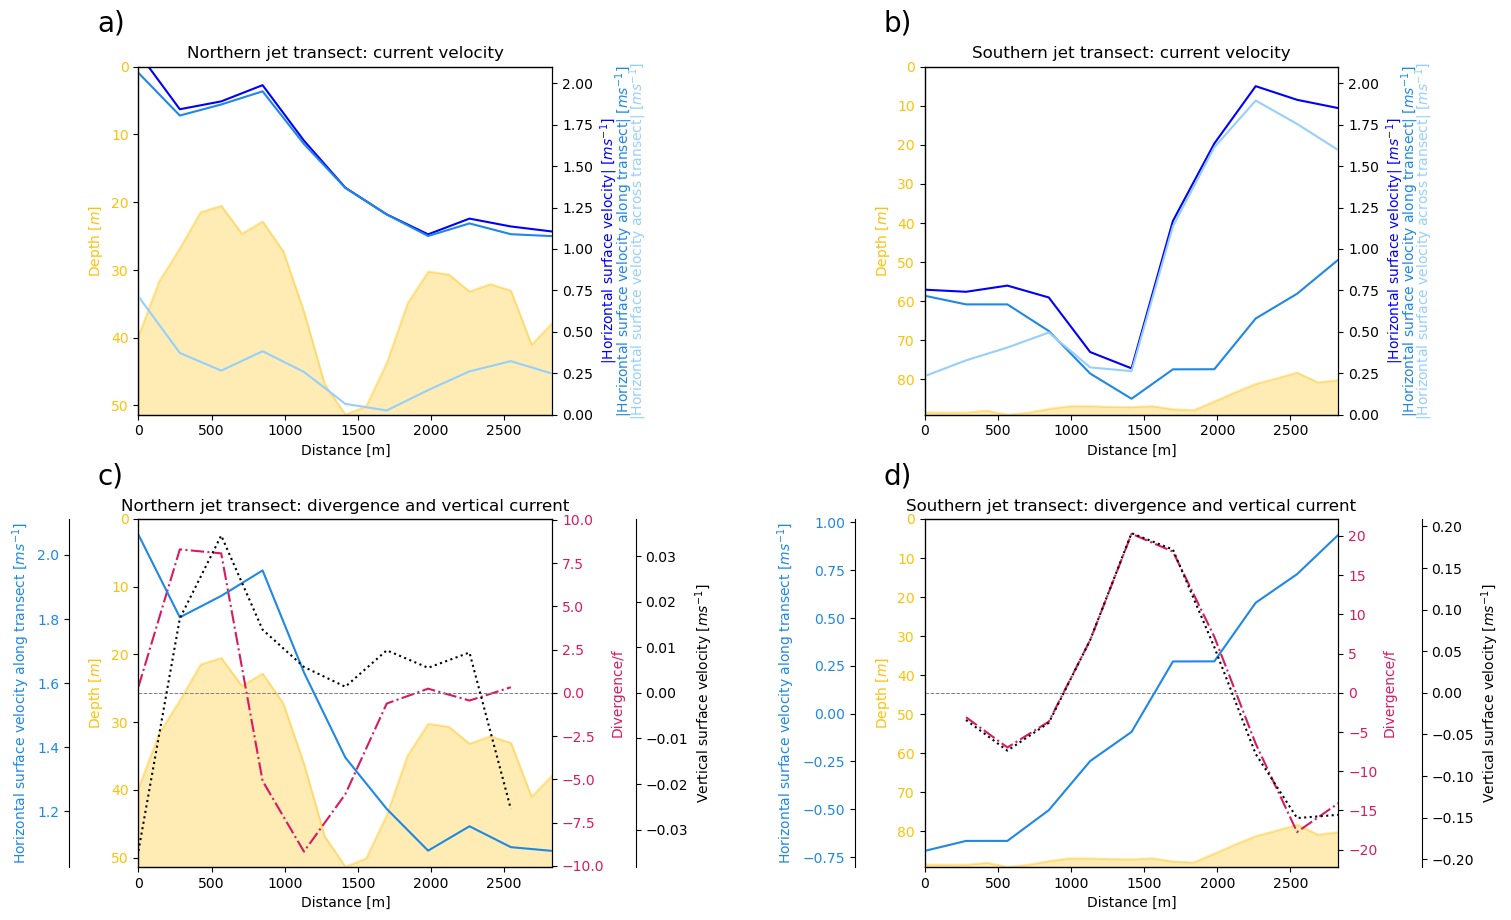

In [27]:
# plot figure 2
current_transects = [current_transect_north, current_transect_south]
elevation_transects = [elevation_transect_north, elevation_transect_south]
plot_transects(current_transects, elevation_transects)

In [28]:
MARS3D["level"]

<xarray.DataArray 'level' (level: 40)>
array([-0.9875, -0.9625, -0.9375, -0.9125, -0.8875, -0.8625, -0.8375, -0.8125,
       -0.7875, -0.7625, -0.7375, -0.7125, -0.6875, -0.6625, -0.6375, -0.6125,
       -0.5875, -0.5625, -0.5375, -0.5125, -0.4875, -0.4625, -0.4375, -0.4125,
       -0.3875, -0.3625, -0.3375, -0.3125, -0.2875, -0.2625, -0.2375, -0.2125,
       -0.1875, -0.1625, -0.1375, -0.1125, -0.0875, -0.0625, -0.0375, -0.0125],
      dtype=float32)
Coordinates:
    time     datetime64[ns] 2022-05-17T09:00:00
  * level    (level) float32 -0.9875 -0.9625 -0.9375 ... -0.0625 -0.0375 -0.0125
Attributes:
    long_name:           sigma level
    axis:                Z
    c_grid_axis_shift:   0.0
    positive:            up
    valid_min:           -1.0
    valid_max:           0.0
    standard_name:       ocean_s_coordinate
    formula_terms:       s: level eta: XE depth: H0 a: theta b: b depth_c: hc
    formula_definition:  z(n,k,j,i) = eta(n,j,i)*(1+s(k)) + depth_c*s(k) + (d...

In [29]:
print(op.tools.utils.find_closest_lon_lat(-5.12, 48.5, MARS3D))
print(op.tools.utils.find_closest_lon_lat(-5.09, 48.41, MARS3D))

(2, 7)
(3, 3)


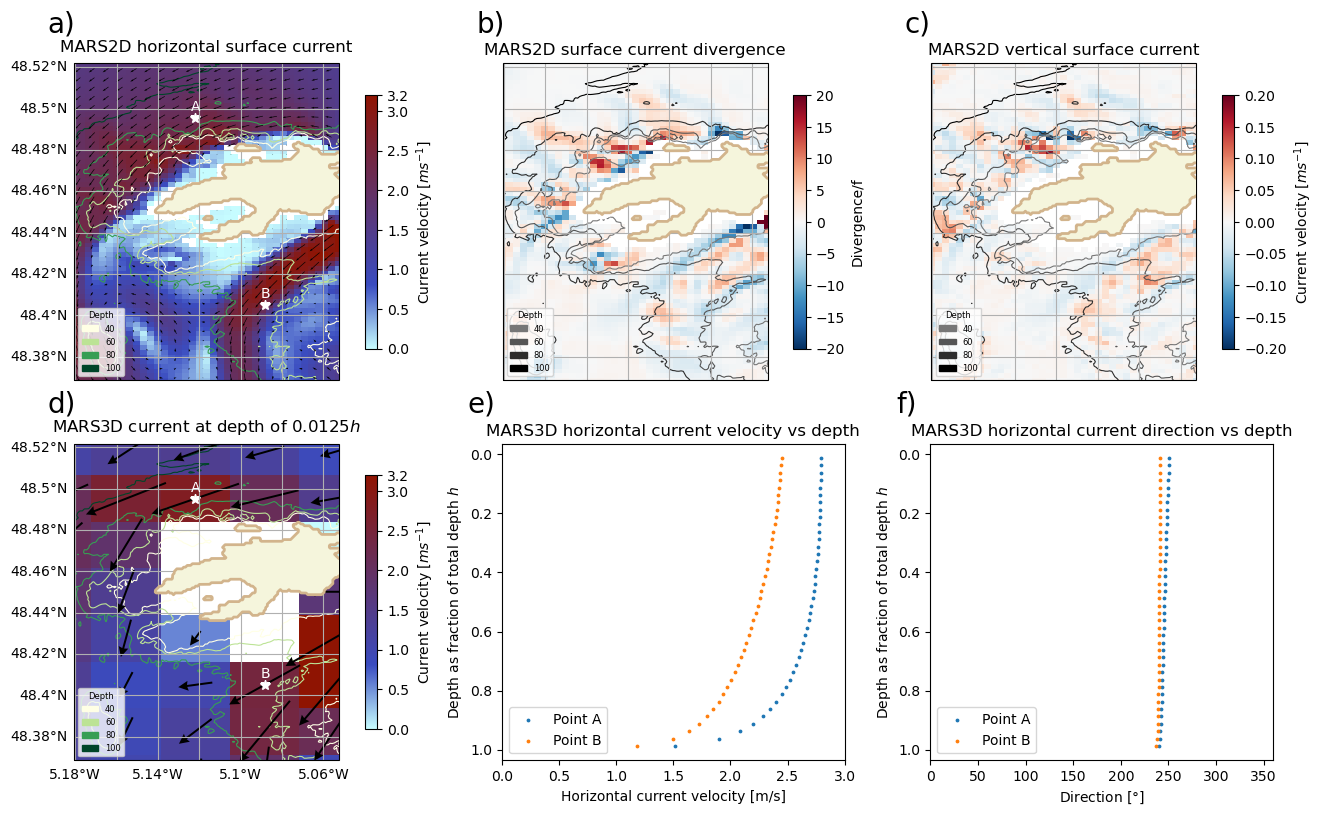

In [30]:
# plot figure 4
_ = plot_MARS2D_and_MARS3D_profiles(
    MARS2D=MARS2D,
    MARS3D=MARS3D,

    points=[(2, 7), (3, 3)],
    bathymetry=bathymetry,

    levels=[-0.0125, -0.6625, -0.9125],
    figsize=(15, 8.5),
    legend_location="lower left",
)